# MSTICPy Pivot Functions

## What are Pivot Functions?

MSTICPy has a lot of functionality distributed across many classes and modules. 
However, there is no simple way to discover where these functions are and what types
of data the function is relevant to.

Pivot functions bring this functionality together grouped around Entities.

Entities are representations real-world objects found commonly in CyberSec investigations.
Some examples are: IpAddress, Host, Account, URL

```python
>>> IpAddress.util.ip_type(ip_str="157.53.1.1"))
ip 	result
157.53.1.1 	Public

>>> IpAddress.util.whois("157.53.1.1"))
asn 	asn_cidr 	asn_country_code 	asn_date 	asn_description 	asn_registry 	nets 	nir 	query 	raw 	raw_referral 	referral
NA 	NA 	US 	2015-04-01 	NA 	arin 	[{'cidr': '157.53.0.0/16', 'name': 'NETACTUATE-MDN-04', 'handle': 'NET-157-53-0-0-1', 'range': '... 	None 	157.53.1.1 	None 	None 	None
                                      
>>> IpAddress.util.geoloc(value="157.53.1.1"))
CountryCode 	CountryName 	State 	City 	Longitude 	Latitude 	Asn 	edges 	Type 	AdditionalData 	IpAddress
US 	United States 	None 	None 	-97.822 	37.751 	None 	{} 	geolocation 	{} 	157.53.1.1
                                      
>>> Host.AzureSentinel.list_host_logons(host_name="VictimPc")
Account 	EventID 	TimeGenerated 	SourceComputerId 	Computer 	SubjectUserName 	SubjectDomainName
NT AUTHORITY\SYSTEM 	4624 	2020-10-01 22:39:36.987000+00:00 	f6638b82-98a5-4542-8bec-6bc0977f793f 	VictimPc.Contoso.Azure 	VictimPc$ 	CONTOSO
NT AUTHORITY\SYSTEM 	4624 	2020-10-01 22:39:37.220000+00:00 	f6638b82-98a5-4542-8bec-6bc0977f793f 	VictimPc.Contoso.Azure 	VictimPc\$ 	CONTOSO
NT AUTHORITY\SYSTEM 	4624 	2020-10-01 22:39:42.603000+00:00 	f6638b82-98a5-4542-8bec-6bc0977f793f 	VictimPc.Contoso.Azure 	VictimPc\$ 	CONTOSO

```

You can also chain pivot functions together to create a processing
pipeline that does multiple operations on data:
```python
>>> (
        suspicious_ips_df
        # Lookup IPs at VT
        .mp_pivot.run(IpAddress.ti.lookup_ipv4_VirusTotal, column="IPAddress")
        # Filter on high severity
        .query("Severity == 'high'")
        .mp_pivot.run(IpAddress.util.whois, column="Ioc", join="left")
        # Query IPs that have login attempts
        .mp_pivot.run(IpAddress.AzureSentinel.list_aad_signins_for_ip, ip_address_list="Ioc")
        # Send the output of this to a plot
        .mp_timeline.plot(
            title="High Severity IPs with Logon attempts",
            source_columns=["UserPrincipalName", "IPAddress", "ClientAppUsed", "Location"],
            group_by="UserPrincipalName"
        )
    )

```

> We'll see examples of how to do these pivoting queries later in the notebook.

MSTICPy has had entity classes from the very early days but, until now, these
have only been used sporadically in the rest of the package.

The pivot functionality exposed operations relevant to a particular
entity as methods of that entity. These operations could include:

- Data queries
- Threat intelligence lookups
- Other data lookups such as GeoLocation or domain resolution
- and other local functionality

## What is Pivoting?

The name comes from the common practice of Cyber investigators navigating
between related entities. For example an entity/investigation chain might
look like the following:


| Step | Source             |  Operation              | Target             |
| :--: | :----------------- | :-----------------      | :----------------- |
| 1    | Alert              | Review alert       ->   | Source IP(A)       |
| 2    | Source IP(A)       | Lookup TI          ->   | Related URLs       |
|      |                    |                         | Malware names      |
| 3    | URL                | Query web logs     ->   | Requesting hosts   |
| 4    | Host               | Query host logons  ->   | Accounts           |


At each step there are one or more directions that you can take to
follow the chain of related indicators of activity in a possible attack.

Bringing these functions into a few, well-known locations makes it easier to
use MSTICPy to carry out this common pivoting pattern in Jupyter notebooks.

---

## Getting started

In [2]:
from msticpy.nbtools.nbinit import init_notebook
init_notebook(namespace=globals());

Processing imports....
Checking configuration....
No errors found.
No warnings found.
Setting notebook options....


The pivoting library depends on a number of data providers used in MSTICPy.
These normally need to be loaded an initialized before starting the Pivot library.

This is mandatory for data query providers such as the AzureSentinel, Splunk or 
MDE data providers. These usually need initialization and authentication steps
to load query definitions and connect to the service. 

> Note: you do not have to authenticate to the data provider before loading Pivot.<br>
> However, some providers are populated with additional queries only after connecting<br>
> to the service. These will not be added to the pivot functions unless you
> create a new Pivot object.

This is optional with providers such as Threat Intelligence (TILookup) and GeoIP.
If you do not initialize these before starting Pivot they will be loaded with
the defaults as specified in your *msticpyconfig.yaml*. If you want to use a 
specific configuration for any of these, you should load and configure them 
before starting Pivot.

### Load one or more data providers

In [3]:
az_provider = QueryProvider("AzureSentinel")

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Initialize the Pivot library

You can either pass an explicit list of providers to Pivot or let it look for them in
the notebook global namespace. In the latter case, the Pivot class will use the
most recently-created instance of each that it finds.

#### What happens at initialization?

- Any instantiated data providers are searched for relevant queries. Any queries found are added to the approriate entity or entities.
- TI provider is loaded and entity-specific lookups (e.g. IP, Url, File) are added as pivot functions
- Miscellaneous Msticpy functions and classes (e.g. GeoIP, IpType, Domain utils) are added as pivot functions to the appropriate entity.

You can add additional functions as pivot functions by creating a registration template and importing the function.
Details of this are covered later in the document.

### Pivot function list

Because we haven't yet loaded the Pivot library nothing is listed.

In [4]:
entities.Host.get_pivot_list()

[]

## Initializing the Pivot library

You will usually see some output as provider libraries are loaded.

In [5]:
from msticpy.datamodel.pivot import Pivot
Pivot(namespace=globals())

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


> Note: Although you can assign the created Pivot object to a variable you normally don't need to do so.<br>
> You can access the current Pivot instance using the class attribute `Pivot.current`

### See the list of providers loaded by the Pivot class

Notice that TILookup was loaded even though we did not create an instance of TILookup beforehand.

In [6]:
Pivot.current.providers

{'AzureSentinel': <msticpy.data.data_providers.QueryProvider at 0x1bb247790c8>,
 'TILookup': <msticpy.sectools.tilookup.TILookup at 0x1bb25d618c8>}

### After loading the Pivot class, entities have pivot functions added to them

In [7]:
print("Host pivot functions\n")
display(entities.Host.get_pivot_list())
print("\nIpAddress pivot functions\n")
display(entities.IpAddress.get_pivot_list())

Host pivot functions



['AzureSentinel.SecurityAlert_list_related_alerts',
 'AzureSentinel.AzureNetworkAnalytics_CL_az_net_analytics',
 'AzureSentinel.AzureNetworkAnalytics_CL_get_ips_for_host',
 'AzureSentinel.Heartbeat_get_heartbeat_for_host',
 'AzureSentinel.AzureNetworkAnalytics_CL_list_azure_network_flows_by_host',
 'AzureSentinel.Heartbeat_get_info_by_hostname',
 'AzureSentinel.AuditLog_CL_auditd_all',
 'AzureSentinel.Syslog_sudo_activity',
 'AzureSentinel.Syslog_cron_activity',
 'AzureSentinel.Syslog_user_group_activity',
 'AzureSentinel.Syslog_all_syslog',
 'AzureSentinel.Syslog_squid_activity',
 'AzureSentinel.Syslog_user_logon',
 'AzureSentinel.Syslog_list_logons_for_host',
 'AzureSentinel.Syslog_list_host_logon_failures',
 'AzureSentinel.SecurityEvent_list_host_events',
 'AzureSentinel.SecurityEvent_list_host_events_by_id',
 'AzureSentinel.SecurityEvent_list_other_events',
 'AzureSentinel.SecurityEvent_get_host_logon',
 'AzureSentinel.SecurityEvent_list_host_logons',
 'AzureSentinel.SecurityEvent 


IpAddress pivot functions



['AzureSentinel.SecurityAlert_list_alerts_for_ip',
 'AzureSentinel.SigninLogs_list_aad_signins_for_ip',
 'AzureSentinel.AzureActivity_list_azure_activity_for_ip',
 'AzureSentinel.AzureNetworkAnalytics_CL_list_azure_network_flows_by_ip',
 'AzureSentinel.OfficeActivity_list_activity_for_ip',
 'AzureSentinel.AzureNetworkAnalytics_CL_get_host_for_ip',
 'AzureSentinel.Heartbeat_get_heartbeat_for_ip',
 'AzureSentinel.Heartbeat_get_info_by_ipaddress',
 'AzureSentinel.Syslog_list_logons_for_source_ip',
 'AzureSentinel.ThreatIntelligenceIndicator_list_indicators',
 'AzureSentinel.ThreatIntelligenceIndicator_list_indicators_by_ip',
 'AzureSentinel.ThreatIntelligenceIndicator_list_indicators_by_hash',
 'AzureSentinel.ThreatIntelligenceIndicator_list_indicators_by_filepath',
 'AzureSentinel.ThreatIntelligenceIndicator_list_indicators_by_domain',
 'AzureSentinel.ThreatIntelligenceIndicator_list_indicators_by_email',
 'AzureSentinel.ThreatIntelligenceIndicator_list_indicators_by_url',
 'ti.lookup_ip

### Pivot functions are grouped into containers

Data queries are grouped into a container with the name of the data provider to which they belong.
E.g. AzureSentinel queries are in a container of that name, Spunk queries would be in a "Splunk" container.

TI lookups are put into a "ti" container

All other built-in functions are added to the "other" container.

The containers themselves are callable and will return a list of their contents. 
Containers are also iterable - each iteration returns a tuple (pair) of name/function values.

In notebooks/IPython you can also use tab completion to get to the right function.

In [8]:
entities.Host.AzureSentinel()

SecurityAlert_list_related_alerts function
AzureNetworkAnalytics_CL_az_net_analytics function
AzureNetworkAnalytics_CL_get_ips_for_host function
Heartbeat_get_heartbeat_for_host function
AzureNetworkAnalytics_CL_list_azure_network_flows_by_host function
Heartbeat_get_info_by_hostname function
AuditLog_CL_auditd_all function
Syslog_sudo_activity function
Syslog_cron_activity function
Syslog_user_group_activity function
Syslog_all_syslog function
Syslog_squid_activity function
Syslog_user_logon function
Syslog_list_logons_for_host function
Syslog_list_host_logon_failures function
SecurityEvent_list_host_events function
SecurityEvent_list_host_events_by_id function
SecurityEvent_list_other_events function
SecurityEvent_get_host_logon function
SecurityEvent_list_host_logons function
SecurityEvent | where EventID == 4625_list_host_logon_failures function
SecurityEvent_list_all_logons_by_host function
SecurityEvent_list_host_processes function
SecurityEvent_get_process_tree function
Security

In [9]:
[query for query, _ in entities.Host.AzureSentinel if "logon" in query]

['Syslog_user_logon',
 'Syslog_list_logons_for_host',
 'Syslog_list_host_logon_failures',
 'SecurityEvent_get_host_logon',
 'SecurityEvent_list_host_logons',
 'SecurityEvent | where EventID == 4625_list_host_logon_failures',
 'SecurityEvent_list_all_logons_by_host']

This is alternative way of listing the pivots for an Entity

In [12]:
entities.Host.pivots()

['AzureSentinel.SecurityAlert_list_related_alerts',
 'AzureSentinel.AzureNetworkAnalytics_CL_az_net_analytics',
 'AzureSentinel.AzureNetworkAnalytics_CL_get_ips_for_host',
 'AzureSentinel.Heartbeat_get_heartbeat_for_host',
 'AzureSentinel.AzureNetworkAnalytics_CL_list_azure_network_flows_by_host',
 'AzureSentinel.Heartbeat_get_info_by_hostname',
 'AzureSentinel.AuditLog_CL_auditd_all',
 'AzureSentinel.Syslog_sudo_activity',
 'AzureSentinel.Syslog_cron_activity',
 'AzureSentinel.Syslog_user_group_activity',
 'AzureSentinel.Syslog_all_syslog',
 'AzureSentinel.Syslog_squid_activity',
 'AzureSentinel.Syslog_user_logon',
 'AzureSentinel.Syslog_list_logons_for_host',
 'AzureSentinel.Syslog_list_host_logon_failures',
 'AzureSentinel.SecurityEvent_list_host_events',
 'AzureSentinel.SecurityEvent_list_host_events_by_id',
 'AzureSentinel.SecurityEvent_list_other_events',
 'AzureSentinel.SecurityEvent_get_host_logon',
 'AzureSentinel.SecurityEvent_list_host_logons',
 'AzureSentinel.SecurityEvent 

## Using the Pivot Browser

Pivot also has a utility that allows you to browse entities and the 
pivot functions attached to them. You can search for functions with
desired keywords, view help for the specific function and copy the function
signature to paste into a code cell.


In [13]:
Pivot.browse()

## Running a pivot function

Pivot functions have flexible input types. They can be used with the following types of parameters:

- entity instances (e.g. where you have an IpAddress entity with a populated address field)
- single values (e.g. a DNS domain name)
- lists of values (e.g. a list of IpAddresses)
- pandas DataFrames (where one or more of the columns contains the input parameter data)

Pivot functions normally return results as a dataframe (although some complex functions such as Notebooklets
can return composite results objects containing multiple dataframes and other object types.


In [10]:
from msticpy.datamodel.entities import IpAddress, Host, Url, Account

In [11]:
print("List 'other' pivot functions for IpAddress\n")
IpAddress.util()
print()
print("-------------------------------\n")
print("Print help for a function - IpAddress.util.type\n")
IpAddress.util.ip_type?

List 'other' pivot functions for IpAddress

whois function
ip_type function
ip_rev_resolve function
geoloc function
geoloc_ips function

-------------------------------

Print help for a function - IpAddress.util.type



Signature: IpAddress.util.ip_type(ip: str = None, ip_str: str = None) -> str
Docstring:
Validate value is an IP address and deteremine IPType category.

(IPAddress category is e.g. Private/Public/Multicast).

Parameters
----------
ip : str
    The string of the IP Address
ip_str : str
    The string of the IP Address - alias for `ip`

Returns
-------
str
    Returns ip type string using ip address module
File:      e:\src\microsoft\msticpy\msticpy\sectools\ip_utils.py
Type:      function


### Parameter names
- Positional parameter - If the function only accepts one parameter you can usually just supply it without a name - as a positional parameter (see first and third examples below)
- Native parameter - You can also use the native parameter name - i.e. the name that the underlying function expects and that will be shown in the help(function) output
- Generic parameter - You can also use the generic parameter name "value" in most cases.

If in doubt, use help(entity.container.func) or entity.container.func?

In [12]:
IpAddress.util.ip_type("10.1.1.1")

,ip,result
0,10.1.1.1,Private


In [13]:
display(IpAddress.util.ip_type("10.1.1.1"))
display(IpAddress.util.ip_type(ip_str="157.53.1.1"))
display(IpAddress.util.whois("157.53.1.1"))
display(IpAddress.util.geoloc(value="157.53.1.1"))

,ip,result
0,10.1.1.1,Private


,ip,result
0,157.53.1.1,Public


,asn,asn_cidr,asn_country_code,asn_date,asn_description,asn_registry,nets,nir,query,raw,raw_referral,referral
0,NA,NA,US,2015-04-01,NA,arin,"[{'cidr': '157.53.0.0/16', 'name': 'NETACTUATE-MDN-04', 'handle': 'NET-157-53-0-0-1', 'range': '...",None,157.53.1.1,None,None,None


,CountryCode,CountryName,State,City,Longitude,Latitude,Asn,edges,Type,AdditionalData,IpAddress
0,US,United States,None,None,-97.822,37.751,None,{},geolocation,{},157.53.1.1


### Using an entity as a parameter

Behind the scenes the Pivot api is using a mapping of
entity attributes to supply the right value to the function parameter.

In [14]:
ip1 = IpAddress(Address="10.1.1.1")
ip2 = IpAddress(Address="157.53.1.1")

display(IpAddress.util.ip_type(ip1))
display(IpAddress.util.ip_type(ip2))
display(IpAddress.util.whois(ip2))
display(IpAddress.util.geoloc(ip2))

,ip,result
0,10.1.1.1,Private


,ip,result
0,157.53.1.1,Public


,asn,asn_cidr,asn_country_code,asn_date,asn_description,asn_registry,nets,nir,query,raw,raw_referral,referral
0,NA,NA,US,2015-04-01,NA,arin,"[{'cidr': '157.53.0.0/16', 'name': 'NETACTUATE-MDN-04', 'handle': 'NET-157-53-0-0-1', 'range': '...",None,157.53.1.1,None,None,None


,CountryCode,CountryName,State,City,Longitude,Latitude,Asn,edges,Type,AdditionalData,IpAddress
0,US,United States,None,None,-97.822,37.751,None,{},geolocation,{},157.53.1.1


### Using a list (or other iterable) as a parameter

Many of the underlying functions will accept either single values or collections 
(usually in DataFrames) of values as input.
Even in cases where the underlying function does not accept iterables as parameters, the
Pivot library will usually be able to iterate through each value and collate the results
to hand you back a single dataframe.

> Note: there are some exceptions to this - usually where the underlying function<br>
> is long-running or expensive and has opted not to accept iterated calls.<br>
> Notebooklets are an example of these.<br>

Where the function has multiple parameters you can supply a mixture of iterables and single values.

- In this case, the single-valued parameters are re-used on each call, paired with the item
  in the list(s) taken from the multi-valued parameters
  
You can also use multiple iterables for multiple parameters.
- In this case the iterables *should* be the same length. 
  If they are different lengths the iterations stop after the shorted list/iterable is exhausted.
  
For example:
```
  list_1 = [1, 2, 3, 4]
  list_2 = ["a", "b", "c"]
  entity.util.func(p1=list_1, p2=list_2)
```

The function will execute with the pairings (1, "a"), (2, "b") and (3, "c) - (4, \_) will be ignored

In [15]:
from msticpy.datamodel import txt_df_magic
md("Use our magic function to convert pasted-in list to dataframe")

In [16]:
%%txt2df --headers --name ip_df1
AllExtIPs
9, 172.217.15.99
10, 40.85.232.64
11, 20.38.98.100
12, 23.96.64.84
13, 65.55.44.108
14, 131.107.147.209
15, 10.0.3.4
16, 10.0.3.5
17, 13.82.152.48

,AllExtIPs
9,172.217.15.99
10,40.85.232.64
11,20.38.98.100
12,23.96.64.84
13,65.55.44.108
14,131.107.147.209
15,10.0.3.4
16,10.0.3.5
17,13.82.152.48


In [17]:
ip_list1 = ip_df1.AllExtIPs.values[-6:]

display(IpAddress.util.ip_type(ip_list1))
display(IpAddress.util.ip_type(ip_str=list(ip_list1)))
display(IpAddress.util.whois(value=tuple(ip_list1)))
display(IpAddress.util.geoloc(ip_list1))

,ip,result
0,23.96.64.84,Public
1,65.55.44.108,Public
2,131.107.147.209,Public
3,10.0.3.4,Private
4,10.0.3.5,Private
5,13.82.152.48,Public


,ip,result
0,23.96.64.84,Public
1,65.55.44.108,Public
2,131.107.147.209,Public
3,10.0.3.4,Private
4,10.0.3.5,Private
5,13.82.152.48,Public


,nir,asn_registry,asn,asn_cidr,asn_country_code,asn_date,asn_description,query,nets,raw,referral,raw_referral
0,NaN,arin,8075,23.96.0.0/14,US,2013-06-18,"MICROSOFT-CORP-MSN-AS-BLOCK, US",23.96.64.84,"[{'cidr': '23.96.0.0/13', 'name': 'MSFT', 'handle': 'NET-23-96-0-0-1', 'range': '23.96.0.0 - 23....",NaN,NaN,NaN
1,NaN,arin,8075,65.52.0.0/14,US,2001-02-14,"MICROSOFT-CORP-MSN-AS-BLOCK, US",65.55.44.108,"[{'cidr': '65.52.0.0/14', 'name': 'MICROSOFT-1BLK', 'handle': 'NET-65-52-0-0-1', 'range': '65.52...",NaN,NaN,NaN
2,NaN,arin,3598,131.107.0.0/16,US,1988-11-11,"MICROSOFT-CORP-AS, US",131.107.147.209,"[{'cidr': '131.107.0.0/16', 'name': 'MICROSOFT', 'handle': 'NET-131-107-0-0-1', 'range': '131.10...",NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,arin,8075,13.64.0.0/11,US,2015-03-26,"MICROSOFT-CORP-MSN-AS-BLOCK, US",13.82.152.48,"[{'cidr': '13.64.0.0/11, 13.104.0.0/14, 13.96.0.0/13', 'name': 'MSFT', 'handle': 'NET-13-64-0-0-...",NaN,NaN,NaN


,CountryCode,CountryName,State,City,Longitude,Latitude,Asn,edges,Type,AdditionalData,IpAddress
0,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},23.96.64.84
1,US,United States,Virginia,Boydton,-78.3750,36.6534,None,{},geolocation,{},65.55.44.108
2,US,United States,Washington,Redmond,-122.1257,47.6722,None,{},geolocation,{},131.107.147.209
3,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},13.82.152.48


### Using DataFrames as input

Using a dataframe as input requires a slightly different syntax since you not
only need to pass the dataframe as a parameter but also tell the function
which column to use for input.

To specify the column to use, you can use the name of the parameter that the
underlying function expects or one of these generic names:

- column
- input_column
- input_col
- src_column
- src_col

> Note these generic names are not shown in the function help

In [18]:
display(IpAddress.util.ip_type(data=ip_df1, input_col="AllExtIPs"))
display(IpAddress.util.ip_type(data=ip_df1, ip="AllExtIPs"))
display(IpAddress.util.whois(data=ip_df1, column="AllExtIPs"))
display(IpAddress.util.geoloc(data=ip_df1, src_col="AllExtIPs"))

,ip,result
0,172.217.15.99,Public
1,40.85.232.64,Public
2,20.38.98.100,Public
3,23.96.64.84,Public
4,65.55.44.108,Public
5,131.107.147.209,Public
6,10.0.3.4,Private
7,10.0.3.5,Private
8,13.82.152.48,Public


,ip,result
0,172.217.15.99,Public
1,40.85.232.64,Public
2,20.38.98.100,Public
3,23.96.64.84,Public
4,65.55.44.108,Public
5,131.107.147.209,Public
6,10.0.3.4,Private
7,10.0.3.5,Private
8,13.82.152.48,Public


,nir,asn_registry,asn,asn_cidr,asn_country_code,asn_date,asn_description,query,nets,raw,referral,raw_referral
9,NaN,arin,15169,172.217.15.0/24,US,2012-04-16,"GOOGLE, US",172.217.15.99,"[{'cidr': '172.217.0.0/16', 'name': 'GOOGLE', 'handle': 'NET-172-217-0-0-1', 'range': '172.217.0...",NaN,NaN,NaN
10,NaN,arin,8075,40.80.0.0/12,US,2015-02-23,"MICROSOFT-CORP-MSN-AS-BLOCK, US",40.85.232.64,"[{'cidr': '40.120.0.0/14, 40.96.0.0/12, 40.112.0.0/13, 40.124.0.0/16, 40.74.0.0/15, 40.125.0.0/1...",NaN,NaN,NaN
11,NaN,arin,8075,20.36.0.0/14,US,2017-10-18,"MICROSOFT-CORP-MSN-AS-BLOCK, US",20.38.98.100,"[{'cidr': '20.34.0.0/15, 20.33.0.0/16, 20.128.0.0/16, 20.36.0.0/14, 20.64.0.0/10, 20.48.0.0/12, ...",NaN,NaN,NaN
12,NaN,arin,8075,23.96.0.0/14,US,2013-06-18,"MICROSOFT-CORP-MSN-AS-BLOCK, US",23.96.64.84,"[{'cidr': '23.96.0.0/13', 'name': 'MSFT', 'handle': 'NET-23-96-0-0-1', 'range': '23.96.0.0 - 23....",NaN,NaN,NaN
13,NaN,arin,8075,65.52.0.0/14,US,2001-02-14,"MICROSOFT-CORP-MSN-AS-BLOCK, US",65.55.44.108,"[{'cidr': '65.52.0.0/14', 'name': 'MICROSOFT-1BLK', 'handle': 'NET-65-52-0-0-1', 'range': '65.52...",NaN,NaN,NaN
14,NaN,arin,3598,131.107.0.0/16,US,1988-11-11,"MICROSOFT-CORP-AS, US",131.107.147.209,"[{'cidr': '131.107.0.0/16', 'name': 'MICROSOFT', 'handle': 'NET-131-107-0-0-1', 'range': '131.10...",NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,arin,8075,13.64.0.0/11,US,2015-03-26,"MICROSOFT-CORP-MSN-AS-BLOCK, US",13.82.152.48,"[{'cidr': '13.64.0.0/11, 13.104.0.0/14, 13.96.0.0/13', 'name': 'MSFT', 'handle': 'NET-13-64-0-0-...",NaN,NaN,NaN


,CountryCode,CountryName,State,City,Longitude,Latitude,Asn,edges,Type,AdditionalData,IpAddress
0,US,United States,None,None,-97.8220,37.7510,None,{},geolocation,{},172.217.15.99
1,CA,Canada,Ontario,Toronto,-79.4195,43.6644,None,{},geolocation,{},40.85.232.64
2,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},20.38.98.100
3,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},23.96.64.84
4,US,United States,Virginia,Boydton,-78.3750,36.6534,None,{},geolocation,{},65.55.44.108
5,US,United States,Washington,Redmond,-122.1257,47.6722,None,{},geolocation,{},131.107.147.209
6,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},13.82.152.48


### Joining input to output data

You might want to return a data set that is joined to your input set.
To do that use the "join" parameter.

The value of join can be:
- inner
- left
- right
- outer

To preserve all rows from the input, use a "left" join.
To keep only rows that have a valid result from the function use "inner" or "right"

> Note while most functions only return a single output row for each input row<br>
> some return multiple rows. Be cautious using "outer" in these cases.

In [19]:
display(IpAddress.util.geoloc(data=ip_df1, src_col="AllExtIPs", join="left"))

,AllExtIPs,CountryCode,CountryName,State,City,Longitude,Latitude,Asn,edges,Type,AdditionalData,IpAddress
0,172.217.15.99,US,United States,None,None,-97.8220,37.7510,None,{},geolocation,{},172.217.15.99
1,40.85.232.64,CA,Canada,Ontario,Toronto,-79.4195,43.6644,None,{},geolocation,{},40.85.232.64
2,20.38.98.100,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},20.38.98.100
3,23.96.64.84,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},23.96.64.84
4,65.55.44.108,US,United States,Virginia,Boydton,-78.3750,36.6534,None,{},geolocation,{},65.55.44.108
5,131.107.147.209,US,United States,Washington,Redmond,-122.1257,47.6722,None,{},geolocation,{},131.107.147.209
6,10.0.3.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10.0.3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13.82.152.48,US,United States,Virginia,Washington,-78.1539,38.7095,None,{},geolocation,{},13.82.152.48


## DataQuery Pivot functions

A significant difference between the functions that we've seen so far
and data query functions is that the latter **do not accept generic parameter names.**

When you use a named parameter in a data query pivot, you must specify
the name that the query function is expecting. If in doubt, use "?" prefix to show the function help.

Example:
```
    Host.AzureSentinel.list_host_events_by_id?
```

In [20]:
ws = WorkspaceConfig(workspace="CyberSecuritySoc")
az_provider.connect(ws.code_connect_str)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Setting time parameters for queries interactively

Use the `edit_query_time` function to set/change the time range used by queries.

With no parameters it defaults to a period of \[*UtcNow - 1 day*\] to \[*UtcNow*\].

Or you can specify a timespan to use with the TimeSpan class.

In [21]:
help(Pivot.edit_query_time)

Help on function edit_query_time in module msticpy.datamodel.pivot:

edit_query_time(self, timespan: Union[msticpy.common.timespan.TimeSpan, NoneType] = None)
    Display a QueryTime widget to get the timespan.
    
    Parameters
    ----------
    timespan : Optional[TimeSpan], optional
        Pre-populate the timespan shown by the QueryTime editor,
        by default None



In [22]:
from msticpy.common.timespan import TimeSpan
ts = TimeSpan(start="2020-10-01", period="1d")
Pivot.current.edit_query_time(timespan=ts)

### Setting the timespan programmatically
You can also just set the timespan directly on the pivot object

In [23]:
Pivot.current.timespan = ts

### What queries do we have?

In [24]:
Host.AzureSentinel()

list_related_alerts function
az_net_analytics function
get_info_by_hostname function
auditd_all function
sudo_activity function
cron_activity function
user_group_activity function
all_syslog function
squid_activity function
user_logon function
list_logons_for_host function
list_host_logon_failures function
get_ips_for_host function
get_heartbeat_for_host function
list_azure_network_flows_by_host function
list_host_events function
list_host_events_by_id function
list_other_events function
get_host_logon function
list_host_logons function
list_all_logons_by_host function
list_host_processes function
get_process_tree function
get_parent_process function
list_processes_in_session function


In [25]:
host = Host(HostName="VictimPc")
Host.AzureSentinel.get_heartbeat_for_host(host)

<IPython.core.display.Javascript object>

,TenantId,SourceSystem,TimeGenerated,MG,ManagementGroupName,SourceComputerId,ComputerIP,Computer,Category,OSType,OSName,OSMajorVersion,OSMinorVersion,Version,SCAgentChannel,IsGatewayInstalled,RemoteIPLongitude,RemoteIPLatitude,RemoteIPCountry,SubscriptionId,ResourceGroup,ResourceProvider,Resource,ResourceId,ResourceType,ComputerEnvironment,Solutions,VMUUID,Type,_ResourceId
0,8ecf8077-cf51-4820-aadd-14040956f35d,OpsManager,2020-12-11 00:08:05.427000+00:00,00000000-0000-0000-0000-000000000001,AOI-8ecf8077-cf51-4820-aadd-14040956f35d,f6638b82-98a5-4542-8bec-6bc0977f793f,13.89.108.248,VictimPc.Contoso.Azure,Direct Agent,Windows,,10,0,10.20.18040.0,Direct,False,-93.61,41.6,United States,d1d8779d-38d7-4f06-91db-9cbc8de0176f,DefendTheFlag,Microsoft.Compute,VictimPc,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/DefendTheFlag/providers/Micro...,virtualMachines,Azure,"""behaviorAnalyticsInsights"", ""security"", ""networkMonitoring"", ""dnsAnalytics"", ""securityCenterFre...",14fa800d-e9b0-4dea-86ac-679933d59253,Heartbeat,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourcegroups/defendtheflag/providers/micro...


In [26]:
Host.AzureSentinel.list_host_logons(host_name="VictimPc").head()

<IPython.core.display.Javascript object>

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,LogonTypeName,AuthenticationPackageName,Status,IpAddress,WorkstationName,TimeCreatedUtc
0,8ecf8077-cf51-4820-aadd-14040956f35d,NT AUTHORITY\SYSTEM,4624,2020-10-01 22:39:36.987000+00:00,f6638b82-98a5-4542-8bec-6bc0977f793f,VictimPc.Contoso.Azure,VictimPc$,CONTOSO,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,5 - Service,Negotiate,,-,-,2020-10-01 22:39:36.987000+00:00
1,8ecf8077-cf51-4820-aadd-14040956f35d,NT AUTHORITY\SYSTEM,4624,2020-10-01 22:39:37.220000+00:00,f6638b82-98a5-4542-8bec-6bc0977f793f,VictimPc.Contoso.Azure,VictimPc$,CONTOSO,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,5 - Service,Negotiate,,-,-,2020-10-01 22:39:37.220000+00:00
2,8ecf8077-cf51-4820-aadd-14040956f35d,NT AUTHORITY\SYSTEM,4624,2020-10-01 22:39:42.603000+00:00,f6638b82-98a5-4542-8bec-6bc0977f793f,VictimPc.Contoso.Azure,VictimPc$,CONTOSO,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,5 - Service,Negotiate,,-,-,2020-10-01 22:39:42.603000+00:00
3,8ecf8077-cf51-4820-aadd-14040956f35d,CONTOSO\RonHD,4624,2020-10-01 22:40:00.957000+00:00,f6638b82-98a5-4542-8bec-6bc0977f793f,VictimPc.Contoso.Azure,VictimPc$,CONTOSO,S-1-5-18,RonHD,CONTOSO,S-1-5-21-1661583231-2311428937-3957907789-1105,0x117a0f7f,Advapi,4,4 - Batch,Negotiate,,-,VictimPc,2020-10-01 22:40:00.957000+00:00
4,8ecf8077-cf51-4820-aadd-14040956f35d,NT AUTHORITY\SYSTEM,4624,2020-10-01 22:40:14.040000+00:00,f6638b82-98a5-4542-8bec-6bc0977f793f,VictimPc.Contoso.Azure,VictimPc$,CONTOSO,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,5 - Service,Negotiate,,-,-,2020-10-01 22:40:14.040000+00:00


### Adding additional parameters

The example below shows using the host entity as an initial parameter
(Pivot is using the attribute mapping assign the `host_name` function parameter the value of `host.fqdn`).

The second parameter is a list of event IDs specified explicitly.

In [27]:
Host.AzureSentinel.list_host_events_by_id?

Signature: Host.AzureSentinel.list_host_events_by_id(*args, **kwargs) -> Union[pandas.core.frame.DataFrame, Any]
Docstring:
Retrieves list of events on a host

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
end: datetime
    Query end time
event_list: list (optional)
    List of event IDs to match
    (default value is: has)
host_name: str
    Name of host
host_op: str (optional)
    The hostname match operator
    (default value is: has)
query_project: str (optional)
    Column project statement
start: datetime
    Query start time
table: str (optional)
    Table name
    (default value is: SecurityEvent)
File:      c:\users\ian\anaconda3\envs\condadev\lib\functools.py
Type:      function


In [28]:
(
    Host.AzureSentinel.list_host_events_by_id( # Pivot query returns DataFrame
        host, event_list=[4624, 4625, 4672]
    )
    [["Computer", "EventID", "Activity"]] # we could have save the output to a dataframe
    .groupby(["EventID", "Activity"])     # variable but we can also use pandas
    .count()                              # functions/syntax directly on the output
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,Computer
EventID,Activity,
4624,4624 - An account was successfully logged on.,520
4672,4672 - Special privileges assigned to new logon.,436


### Using iterables as parameters to data queries

Some data queries accept "list" items as parameters (e.g. many of the IP queries accept a
list of IP addresses). These work as expected, with a single query calling sending the whole list
as a single parameter.

In [29]:
ip_list = [
    "203.23.68.64",
    "67.10.68.45",
    "182.69.173.164",
    "79.176.167.161",
    "167.220.197.230",
]

IpAddress.AzureSentinel()

list_alerts_for_ip function
list_aad_signins_for_ip function
list_azure_activity_for_ip function
list_azure_network_flows_by_ip function
list_activity_for_ip function
get_info_by_ipaddress function
list_logons_for_source_ip function
get_host_for_ip function
get_heartbeat_for_ip function
list_indicators function
list_indicators_by_ip function
list_indicators_by_hash function
list_indicators_by_filepath function
list_indicators_by_domain function
list_indicators_by_email function
list_indicators_by_url function


In [30]:
IpAddress.AzureSentinel.list_aad_signins_for_ip?

Signature: IpAddress.AzureSentinel.list_aad_signins_for_ip(*args, **kwargs) -> Union[pandas.core.frame.DataFrame, Any]
Docstring:
Lists Azure AD Signins for an IP Address

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
end: datetime (optional)
    Query end time
ip_address_list: list
    The IP Address or list of Addresses
start: datetime (optional)
    Query start time
    (default value is: -5)
table: str (optional)
    Table name
    (default value is: SigninLogs)
File:      c:\users\ian\anaconda3\envs\condadev\lib\functools.py
Type:      function


In [31]:
IpAddress.AzureSentinel.list_aad_signins_for_ip(ip_address_list=ip_list).head(5)

<IPython.core.display.Javascript object>

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,IsRisky,LocationDetails,MfaDetail,NetworkLocationDetails,OriginalRequestId,ProcessingTimeInMilliseconds,RiskDetail,RiskEventTypes,RiskEventTypes_V2,RiskLevelAggregated,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type
0,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2020-10-01 10:02:18.923000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,ac81524b-bb83-4a0a-a3f8-577a14dda295,Microsoft.aadiam,Microsoft.aadiam,,Brandon,4,US,,Azure Advanced Threat Protection,7b7531ad-5926-4f2d-8a1d-38495ad33e17,[],,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,None,"{'city': 'Lewisville', 'state': 'Texas', 'countryOrRegion': 'US', 'geoCoordinates': {'latitude':...",None,[],c2bcb991-75ad-42f4-a6c0-1a90686dfd00,210,none,[],[],none,none,none,Azure Advanced Threat Protection,7b7531ad-5926-4f2d-8a1d-38495ad33e17,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.427...",Brandon,9dadd76f-3237-4e1d-84e7-e45c59867492,brandon@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs
1,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2020-10-01 13:02:35.003000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,7ad7aeab-9b3e-4463-844a-e458cc3b1ae7,Microsoft.aadiam,Microsoft.aadiam,,Brandon,4,US,,Azure Advanced Threat Protection,7b7531ad-5926-4f2d-8a1d-38495ad33e17,[],,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,None,"{'city': 'Lewisville', 'state': 'Texas', 'countryOrRegion': 'US', 'geoCoordinates': {'latitude':...",None,[],67780cc7-0610-409d-82c8-f9603b238100,140,none,[],[],none,none,none,Azure Advanced Threat Protection,7b7531ad-5926-4f2d-8a1d-38495ad33e17,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.427...",Brandon,9dadd76f-3237-4e1d-84e7-e45c59867492,brandon@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs
2,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2020-10-01 12:02:29.023000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,df38d091-bff5-49b4-8a4f-d37c0fd4f425,Microsoft.aadiam,Microsoft.aadiam,,Brandon,4,US,,Azure Advanced Threat Protection,7b7531ad-5926-4f2d-8a1d-38495ad33e17,[],,"[\r\n {\r\n ""key"": ""IsCAEToken"",\r\n ""value"": ""False""\r\n }\r\n]",singleFactorAuthentication,...,None,"{'city': 'Lewisville', 'state': 'Texas', 'countryOrRegion': 'US', 'geoCoordinates': {'latitude':...",None,[],1c276715-4518-4b42-8a34-827162f17a00,203,none,[],[],none,none,none,Azure Advanced Threat Protection,7b7531ad-5926-4f2d-8a1d-38495ad33e17,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.427...",Brandon,9dadd76f-3237-4e1d-84e7-e45c59867492,brandon@seccxpninja.onmicrosoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs
3,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2020-10-01 11:02:23.922000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,a80366d7-3efe-49ad-860d-8e9ebc53832f,Microsoft.aadiam,Microsoft.aadiam,,Brandon,4,US,,Azure Advanced Threat Protection,7b7531ad-

### Using iterable values where the query function was designed to only accept single values

In this case the pivot function will iterate through the values of the
iterable, making a separate query for each and then joining the results.

We can see that this function only accepts a single value for "account_name".

In [32]:
Account.AzureSentinel.list_aad_signins_for_account?

Signature: Account.AzureSentinel.list_aad_signins_for_account(*args, **kwargs) -> Union[pandas.core.frame.DataFrame, Any]
Docstring:
Lists Azure AD Signins for Account

Parameters
----------
account_name: str
    The account name to find
add_query_items: str (optional)
    Additional query clauses
end: datetime (optional)
    Query end time
start: datetime (optional)
    Query start time
    (default value is: -5)
table: str (optional)
    Table name
    (default value is: SigninLogs)
File:      c:\users\ian\anaconda3\envs\condadev\lib\functools.py
Type:      function


In [33]:
accounts = [
    "ofshezaf",
    "moshabi",
]
Account.AzureSentinel.list_aad_signins_for_account(account_name=accounts)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,IsRisky,LocationDetails,MfaDetail,NetworkLocationDetails,OriginalRequestId,ProcessingTimeInMilliseconds,RiskDetail,RiskEventTypes,RiskEventTypes_V2,RiskLevelAggregated,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type
0,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2020-10-01 11:04:42.689000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,2e6fd17c-1227-433e-b3a3-80a74374a7dc,Microsoft.aadiam,Microsoft.aadiam,,Ofer Shezaf,4,IL,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],,"[\r\n {\r\n ""key"": ""Login Hint Present"",\r\n ""value"": ""True""\r\n },\r\n {\r\n ""key"":...",multiFactorAuthentication,...,None,"{'city': 'Tiberias', 'state': 'Hazafon', 'countryOrRegion': 'IL', 'geoCoordinates': {'latitude':...",{},[],c8bfc04f-28bf-40b4-a9c1-07fd5bd9f800,918,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,"{'errorCode': 0, 'additionalDetails': 'MFA requirement satisfied by claim in the token'}",,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.418...",Ofer Shezaf,9c459db5-0407-43fe-a2ea-126757297beb,ofshezaf@microsoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs
1,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2020-10-01 11:19:36.626000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,4bdf65b2-99af-4bd4-ab7c-ffbc5a1d5038,Microsoft.aadiam,Microsoft.aadiam,,Mor Shabi,4,IL,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],,"[\r\n {\r\n ""key"": ""Login Hint Present"",\r\n ""value"": ""True""\r\n },\r\n {\r\n ""key"":...",multiFactorAuthentication,...,None,"{'city': 'Herzliya', 'state': 'Tel Aviv', 'countryOrRegion': 'IL', 'geoCoordinates': {'latitude'...",{},[],4a40c63d-5e43-4af0-a0e5-2ae5df81e500,3600,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,"{'errorCode': 0, 'additionalDetails': 'MFA requirement satisfied by claim in the token'}",,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.418...",Mor Shabi,7b77cfef-7ac7-4121-a834-561291927ad1,moshabi@microsoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs
2,8ecf8077-cf51-4820-aadd-14040956f35d,Azure AD,2020-10-01 11:19:40.787000+00:00,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,,0,4460b859-84c1-4751-bddb-b305516cbed4,Microsoft.aadiam,Microsoft.aadiam,,Mor Shabi,4,IL,,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],,"[\r\n {\r\n ""key"": ""Login Hint Present"",\r\n ""value"": ""True""\r\n },\r\n {\r\n ""key"":...",singleFactorAuthentication,...,None,"{'city': 'Herzliya', 'state': 'Tel Aviv', 'countryOrRegion': 'IL', 'geoCoordinates': {'latitude'...",{},[],4a40c63d-5e43-4af0-a0e5-2ae5c182e500,1526,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,,,{'errorCode': 0},,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.418...",Mor Shabi,7b77cfef-7ac7-4121-a834-561291927ad1,moshabi@microsoft.com,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs


### Combining multiple iterables and single-valued parameters

The same rules as outline earlier for multiple parameters of different types apply to data queries

In [34]:
project = "| project UserPrincipalName, Identity"
Account.AzureSentinel.list_aad_signins_for_account(account_name=accounts, add_query_items=project)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,UserPrincipalName,Identity
0,ofshezaf@microsoft.com,Ofer Shezaf
1,moshabi@microsoft.com,Mor Shabi
2,moshabi@microsoft.com,Mor Shabi


### Using DataFrames as input

This is similar to using dataframes for other pivot functions.

We must use the `data` parameter to specify the input dataframe.
You supply the column name from your input dataframe as the value of
the parameters expected by the function.

In [35]:
account_df = pd.DataFrame(accounts, columns=["User"])
display(account_df)

,User
0,ofshezaf
1,moshabi


Now we have our dataframe:

- we specify `account_df` as the value of the `data` parameter.
- in our source (input) dataframe, the column that we want to use as the input value for each query is `User`
- we specify that column name as the value of the function parameter

On each iteration, the column value from a subsequent row will be extracted and 
given as the parameter value for the function parameter.

> Note:<br> 
> If the function parameter type is a "list" type - i.e. it expects a list of values<br>
> the parameter value will be sent as a list and only a single query is executed.<br>
> If the query function has multiple "list" type parameters, these will be<br>
> populated in the same way.

> Note2:<br>
> If you have multiple parameters fed by multiple input columns AND one or more<br>
> of the function parameters *is not* a list type, the the query will be broken<br>
> into queries for each row. Each sub-query getting its values from a single row<br>
> of the input dataframe.

In [36]:
Account.AzureSentinel.list_aad_signins_for_account(data=account_df, account_name="User", add_query_items=project)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,UserPrincipalName,Identity
0,ofshezaf@microsoft.com,Ofer Shezaf
1,moshabi@microsoft.com,Mor Shabi
2,moshabi@microsoft.com,Mor Shabi


## Threat Intelligence Lookups

These work in the same way as the functions described earlier. However,
there are a few peculiarities of the Threat Intel functions:

### Provider-specific functions
Queries for individual providers are broken out into separate functions
You will see multiple `lookup_ipv4` functions, for example: one with no suffix
and one for each individual TI provider with a corresponding suffix.
This is a convenience to let you use a specific provider more quickly. You
can still use the generic function (`lookup_ipv4`) and supply a providers parameter
to indicate which providers you want to use.

### IPV4 and IPV6
Some providers treat these interchangably and use the same endpoint for both.
Other providers do not explicitly support IPV6 (e.g. the Tor exit nodes provider).
Still others (notably OTX) use different endpoints for IPv4 and IPv6.

If you are querying IPv4 you can use either the `lookup_ip` function or one
of the `lookup_ipv4` functions. In most cases, you can also use these functions
for a mixture of IPv4 and v6 addresses. However, in cases where a provider
does not support IPv6 or uses a different endpoint for IPv6 queries you
will get no responses.

### Entity mapping to IoC Types
This table shows the mapping between and entity type
and IoC Types:

| Entity     |  IoCType           |
| :--------- | :----------------- |
| IpAddress  | ipv4, ipv6         |
| Dns        | domain             |
| File       | filehash (incl     |
|            | md5, sha1, sha256) |
| Url        | url                |

> Note: Where you are using a File entity as a parameter, there is a complication.<br>
> A file entity can have multiple hash values (md5, sha1, sha256 and even sha256 authenticode).<br>
> The `file_hash` attibute of File is used as the default parameter.<br>
> In cases where a file has multiple hashes the highest priority hash (in order<br>
> sha256, sha1, md5, sha256ac) is returned.<br>
> If you are not using file entities as parameters (and specifying the input values<br>
> explicitly or via a Dataframe or iterable, you can ignore this.

In [37]:
IpAddress.ti()

lookup_ip function
lookup_ipv4 function
lookup_ipv4_OTX function
lookup_ipv4_Tor function
lookup_ipv4_VirusTotal function
lookup_ipv4_XForce function
lookup_ipv6 function
lookup_ipv6_OTX function


In [38]:
from msticpy.datamodel.entities import Url, Dns, File
dns = Dns(DomainName="fkksjobnn43.org")

Dns.ti.lookup_dns(dns)

,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,fkksjobnn43.org,dns,fkksjobnn43.org,None,OTX,True,high,"{'pulse_count': 35, 'names': ['Jaff - Malware Domain Feed V2', 'Jaff - Malware Domain Feed V2', ...","{'sections': ['general', 'geo', 'url_list', 'passive_dns', 'malware', 'whois', 'http_scans'], 'w...",https://otx.alienvault.com/api/v1/indicators/domain/fkksjobnn43.org/general,0
0,fkksjobnn43.org,dns,,None,OPR,True,warning,"{'rank': None, 'error': 'Domain not found'}","{'status_code': 404, 'error': 'Domain not found', 'page_rank_integer': 0, 'page_rank_decimal': 0...",https://openpagerank.com/api/v1.0/getPageRank?domains[0]=fkksjobnn43.org,0
0,fkksjobnn43.org,dns,fkksjobnn43.org,None,VirusTotal,True,information,"{'verbose_msg': 'Domain found in dataset', 'response_code': 1, 'detected_urls': ['http://fkksjob...","{'undetected_downloaded_samples': [], 'whois_timestamp': 1607400917, 'detected_downloaded_sample...",https://www.virustotal.com/vtapi/v2/domain/report,0
0,fkksjobnn43.org,dns,fkksjobnn43.org,None,XForce,True,information,"{'score': 0, 'cats': None, 'categoryDescriptions': None, 'reason': None, 'reasonDescription': 0,...","{'result': {'url': 'fkksjobnn43.org', 'cats': {'General Business': True}, 'score': 1, 'categoryD...",https://api.xforce.ibmcloud.com/url/fkksjobnn43.org,0


In [39]:
Dns.ti.lookup_dns(value="fkksjobnn43.org")

,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,fkksjobnn43.org,dns,fkksjobnn43.org,None,OTX,True,high,"{'pulse_count': 35, 'names': ['Jaff - Malware Domain Feed V2', 'Jaff - Malware Domain Feed V2', ...","{'sections': ['general', 'geo', 'url_list', 'passive_dns', 'malware', 'whois', 'http_scans'], 'w...",https://otx.alienvault.com/api/v1/indicators/domain/fkksjobnn43.org/general,0
0,fkksjobnn43.org,dns,,None,OPR,True,warning,"{'rank': None, 'error': 'Domain not found'}","{'status_code': 404, 'error': 'Domain not found', 'page_rank_integer': 0, 'page_rank_decimal': 0...",https://openpagerank.com/api/v1.0/getPageRank?domains[0]=fkksjobnn43.org,0
0,fkksjobnn43.org,dns,fkksjobnn43.org,None,VirusTotal,True,information,"{'verbose_msg': 'Domain found in dataset', 'response_code': 1, 'detected_urls': ['http://fkksjob...","{'undetected_downloaded_samples': [], 'whois_timestamp': 1607400917, 'detected_downloaded_sample...",https://www.virustotal.com/vtapi/v2/domain/report,0
0,fkksjobnn43.org,dns,fkksjobnn43.org,None,XForce,True,information,"{'score': 0, 'cats': None, 'categoryDescriptions': None, 'reason': None, 'reasonDescription': 0,...","{'result': {'url': 'fkksjobnn43.org', 'cats': {'General Business': True}, 'score': 1, 'categoryD...",https://api.xforce.ibmcloud.com/url/fkksjobnn43.org,0


In [40]:
hashes = [
    "02a7977d1faf7bfc93a4b678a049c9495ea663e7065aa5a6caf0f69c5ff25dbd",
    "06b020a3fd3296bc4c7bf53307fe7b40638e7f445bdd43fac1d04547a429fdaf",
    "06c676bf8f5c6af99172c1cf63a84348628ae3f39df9e523c42447e2045e00ff",
]

File.ti.lookup_file_hash_VirusTotal(hashes)

,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,02a7977d1faf7bfc93a4b678a049c9495ea663e7065aa5a6caf0f69c5ff25dbd,sha256_hash,02a7977d1faf7bfc93a4b678a049c9495ea663e7065aa5a6caf0f69c5ff25dbd,None,VirusTotal,True,high,"{'verbose_msg': 'Scan finished, information embedded', 'response_code': 1, 'resource': '02a7977d...","{'scans': {'Bkav': {'detected': True, 'version': '1.3.0.9899', 'result': 'W32.AIDetectVM.malware...",https://www.virustotal.com/vtapi/v2/file/report,0
1,06b020a3fd3296bc4c7bf53307fe7b40638e7f445bdd43fac1d04547a429fdaf,sha256_hash,06b020a3fd3296bc4c7bf53307fe7b40638e7f445bdd43fac1d04547a429fdaf,None,VirusTotal,True,high,"{'verbose_msg': 'Scan finished, information embedded', 'response_code': 1, 'resource': '06b020a3...","{'scans': {'Bkav': {'detected': False, 'version': '1.3.0.9899', 'result': None, 'update': '20201...",https://www.virustotal.com/vtapi/v2/file/report,0
2,06c676bf8f5c6af99172c1cf63a84348628ae3f39df9e523c42447e2045e00ff,sha256_hash,06c676bf8f5c6af99172c1cf63a84348628ae3f39df9e523c42447e2045e00ff,None,VirusTotal,True,high,"{'verbose_msg': 'Scan finished, information embedded', 'response_code': 1, 'resource': '06c676bf...","{'scans': {'Bkav': {'detected': True, 'version': '1.3.0.9899', 'result': 'W32.AIDetectVM.malware...",https://www.virustotal.com/vtapi/v2/file/report,0


### Lookup from a DataFrame

To specify the source column you can use either "column" or "obs_column"

In [41]:
hashes_df = pd.DataFrame(
    [(fh, f"item_{idx}", "stuff") for idx, fh in enumerate(hashes)],
    columns=["hash", "ref", "desc"],
)
display(hashes_df)
File.ti.lookup_file_hash_VirusTotal(data=hashes_df, column="hash")

,hash,ref,desc
0,02a7977d1faf7bfc93a4b678a049c9495ea663e7065aa5a6caf0f69c5ff25dbd,item_0,stuff
1,06b020a3fd3296bc4c7bf53307fe7b40638e7f445bdd43fac1d04547a429fdaf,item_1,stuff
2,06c676bf8f5c6af99172c1cf63a84348628ae3f39df9e523c42447e2045e00ff,item_2,stuff


,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,02a7977d1faf7bfc93a4b678a049c9495ea663e7065aa5a6caf0f69c5ff25dbd,sha256_hash,02a7977d1faf7bfc93a4b678a049c9495ea663e7065aa5a6caf0f69c5ff25dbd,None,VirusTotal,True,high,"{'verbose_msg': 'Scan finished, information embedded', 'response_code': 1, 'resource': '02a7977d...","{'scans': {'Bkav': {'detected': True, 'version': '1.3.0.9899', 'result': 'W32.AIDetectVM.malware...",https://www.virustotal.com/vtapi/v2/file/report,0
1,06b020a3fd3296bc4c7bf53307fe7b40638e7f445bdd43fac1d04547a429fdaf,sha256_hash,06b020a3fd3296bc4c7bf53307fe7b40638e7f445bdd43fac1d04547a429fdaf,None,VirusTotal,True,high,"{'verbose_msg': 'Scan finished, information embedded', 'response_code': 1, 'resource': '06b020a3...","{'scans': {'Bkav': {'detected': False, 'version': '1.3.0.9899', 'result': None, 'update': '20201...",https://www.virustotal.com/vtapi/v2/file/report,0
2,06c676bf8f5c6af99172c1cf63a84348628ae3f39df9e523c42447e2045e00ff,sha256_hash,06c676bf8f5c6af99172c1cf63a84348628ae3f39df9e523c42447e2045e00ff,None,VirusTotal,True,high,"{'verbose_msg': 'Scan finished, information embedded', 'response_code': 1, 'resource': '06c676bf...","{'scans': {'Bkav': {'detected': True, 'version': '1.3.0.9899', 'result': 'W32.AIDetectVM.malware...",https://www.virustotal.com/vtapi/v2/file/report,0


## Chaining pivot and other functions

Because pivot functions can take dataframes as inputs and return them
as outputs, you can create chains of pivot functions.
You can also add other items to the chain that input or output
dataframes.

For example, you could build a chain that included the following:
- take IP addresses from firewall alerts
- lookup the IPs in Threat Intel providers filtering those that have high severity
- lookup the any remote logon events sourced at those IPs
- display a timeline of the logons

To make building these types of pipelines easier we've implemented some
pandas helper functions. These are available in the `mp_pivot`
property of pandas DataFrames, once Pivot is imported.

### mp_pivot.run

`run` lets you run a pivot function as a pandas pipeline operation.
 
Let's take an example of a simple pivot function using a dataframe as input
```
    IpAddress.util.whois(data=my_df, column="Ioc")
```

We can us mp_pivot.run to do this:
```
 (
     my_df
     .query("UserCount > 1")
     .mp_pivot.run(IpAddress.util.whois, column="Ioc")
     .drop_duplicates()
 )
```
The pandas extension takes care of the `data=my_df` parameter. We still have
to add any other required parameters (like the column specification in this case.
When it runs it returns its output as a DataFrame and the next operation
(drop_duplicates()) runs on this output.

Depending on the scenario you might want to preserve the existing dataframe
contents (most of the pivot functions only return the results of their specific
operation - e.g. whois returns ASN information for an IP address). You
can carry the columns of the input dataframe over to the output from 
the pivot function by adding a `join` parameter to the mp_pivot.run() call.
Use a "left" to keep all of the input rows regardless of whether the pivot
function returned a result for that row.
Use an "inner" join to return only rows where the input had a positive result
in the pivot function.
```
    .mp_pivot.run(IpAddress.util.whois, column="Ioc", join="inner")
```

There are also a couple of convenience functions. These only work in
an IPython/Jupyter environment.

### mp_pivot.display

`mp_pivot.display` will display the intermediate results of the dataframe in the middle
of a pipeline. It does not change the data at all, but does give you the 
chance to display a view of the data partway through processing. This
is useful for debugging but its main purpose is to give you a way to
show partial results without having to break the pipeline into pieces
and create unnecessary throw-away variables that will add bulk to your
code and clutter to your memory.

`display` supports some options that you can use to modify the displayed
output:

- title - displays a title above the data
- cols - a list of columns to display (others are hidden)
- query - you can filter the output using a df.query() string. See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html?highlight=query#pandas.DataFrame.query
  for more details
- head - limits the display to the first `head` rows

These options do not affect the data being passed through the pipeline -
only how the intermediate output is displayed.

### mp_pivot.tee
`mp_pivot.tee` behaves a little like the Linux "tee" command. It allows the
data to pass through unchanged but allows you to create a variable that
is a snapshot of the data at that point in the pipeline. It takes
a parameter `var_name` and assigns the current DataFrame instance
to that name. So, when your pipeline has run you can access partial results (again,
without having to break up your pipeline to do so).

By default, it will not overwrite an existing variable of the same name
unless you specify `clobber=True` in the call to `tee`.

### mp_pivot.tee_exec
behaves similarly to the "tee" function above except that it
will try to execute the DataFrame accessor function on the input
DataFrame. The name of the function (as a string) can be passed named as the value of the
`df_func` named parameter, or the first positional.
The function **must** be a method of a pandas DataFrame - this includes
built-in functions such as `.query`, `.sort_values` or a custom function
added as a custom pd accessor function (see 
[Extending pandas](https://pandas.pydata.org/pandas-docs/stable/development/extending.html?highlight=accessor))

`mp_pivot.tee_exec` allows the input
data to pass through unchanged but will also send
a snapshot of the data at that point in the pipeline to the named function.
You can also pass arbitrary other named arguments to the `tee_exec`. These arguments will be passed to the `df_func` function.

### Example
The example below shows the use of mp_pivot.run and mp_pivot.display.

This takes an existing DataFrame - suspcious_ips - and:

- displays the top 5 rows of the dataframe
- checks for threat intelligence reports on any of the IP addresses
- uses pandas `query` to filter only the high severity hits
- calls the whois pivot function to obtain ownership information for these IPs
  (note that we join the results of the previous step here usine `join='left'`
  so our output will be all TI result data plus whois data
- calls a pivot data query to check for Azure Active Directory logins that
  have an IP address source that matches any of these addresses.
  
The final step uses another MSTICPy pandas extension to plot the login attempts
on a timeline chart.

In [42]:
suspicious_ips = [
    "113.190.36.2",
    "118.163.135.17",
    "118.163.135.18",
    "118.163.97.19",
    "125.34.240.33",
    "135.26.152.186",
    "165.225.17.6",
    "177.135.101.5",
    "177.159.99.89",
    "177.19.187.79",
    "186.215.197.15",
    "186.215.198.137",
    "189.59.5.81",
]
suspicious_ips_df = pd.DataFrame(suspicious_ips, columns=["IPAddress"])

In [ ]:
(
    suspicious_ips_df
    .mp_pivot.display(title=f"Initial IPs {len(suspicious_ips)}", head=5)
    # Lookup IPs at VT
    .mp_pivot.run(IpAddress.ti.lookup_ipv4_VirusTotal, column="IPAddress")
    # Filter on high severity
    .query("Severity == 'high'")
    .mp_pivot.run(IpAddress.util.whois, column="Ioc", join="left")
    .mp_pivot.display(title="TI High Severity IPs", head=5)
    # Query IPs that have login attempts
    .mp_pivot.run(IpAddress.AzureSentinel.list_aad_signins_for_ip, ip_address_list="Ioc")
    # Send the output of this to a plot
    .mp_timeline.plot(
        title="High Severity IPs with Logon attempts",
        source_columns=["UserPrincipalName", "IPAddress", "ResultType", "ClientAppUsed", "UserAgent", "Location"],
        group_by="UserPrincipalName"
    )
)

### Example output from pipelined functions

This is what the pipelined functions should output (although the results
will obviously not be the same for your environment).

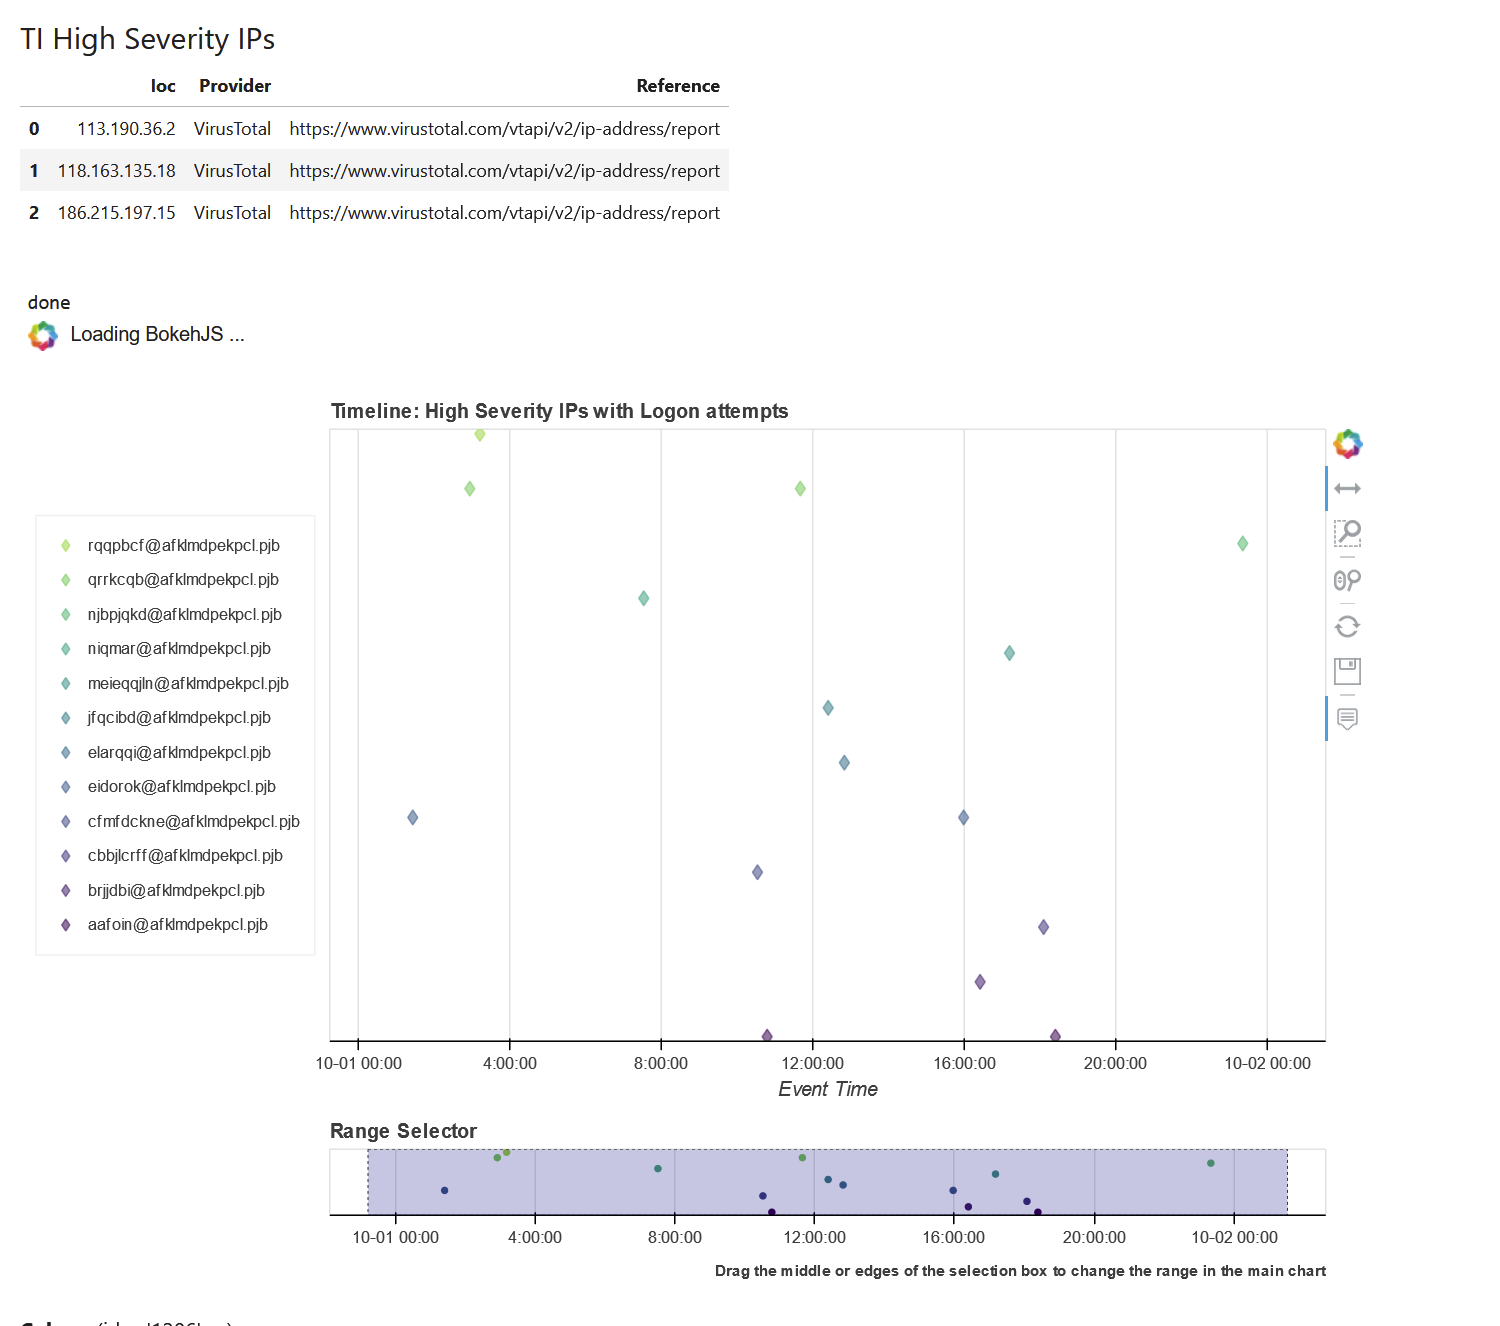

## Adding custom functions to the pivot interface

To do this you need the following information

| Item                   | Description                                                                 | Required    |
| :--------------------- | :--------------------------                                                 | :---------- |
| src_module             | The src_module to containing the class or function                          | Yes         |
| class                  | The class containing function                                               | No          |
| src_func_name          | The name of the function to wrap                                            | Yes         |
| func_new_name          | Rename the function                                                         | No          |
| input type             | The input type that the wrapped function expects (dataframe iterable value) | Yes         |
| entity_map             | Mapping of entity and attribute used for function                           | Yes         |
| func_df_param_name     | The param name that the function uses as input param for DataFrame          | If DF input |
| func_df_col_param_name | The param name that function uses to identify the input column name         | If DF input |
| func_out_column_name   | Name of the column in the output DF to use as a key to join                 | If DF output|
| func_static_params     | dict of static name/value params always sent to the function                | No          |
| func_input_value_arg   | Name of the param that the wrapped function uses for its input value        | No          |
| can_iterate            | True if the function supports being called multiple times                   | No          |
| entity_container_name  | The name of the container in the entity where the func will appear          | No          |


The entity_map controls where the pivot function will be added. Each entry
requires an Entity name (see msticpy.datamodel.entities) and an entity
attribute name. This is only used if an instance of the entity is used
as a parameter to the function. For `IpAddress` in the example below,
the pivot function will try to extract the value of the `Address` attribute
when an instance of IpAddress is used as a function parameter.

```yaml
  entity_map:
     IpAddress: Address
     Host: HostName
     Account: Name
```

This means that you can specify different attributes of the same entity
for different functions (or even for two instances of the same function)

The `func_df_param_name` and `func_df_col_param_name` are needed only if
the source function takes a dataframe and column name as input parameters.

`func_out_column_name` is relevant if the source function returns a
dataframe. In order to join input data with output data this needs to
be the column in the output that has the same value as the function
input (e.g. if you are processing IP addresses and the column name
in the output DF containing the IP is named "ip_addr", put "ip_addr" here.)

When you have this information create or add this to a yaml file
with the top-level element `pivot_providers`.

Example from the msticpy ip_utils `who_is` function
```yaml
pivot_providers:
  ...
  who_is:
    src_module: msticpy.sectools.ip_utils
    src_func_name: get_whois_df
    func_new_name: whois
    input_type: dataframe
    entity_map:
      IpAddress: Address
    func_df_param_name: data
    func_df_col_param_name: ip_column
    func_out_column_name: ip
    func_static_params:
      whois_col: whois_result
    func_input_value_arg: ip_address
```

Once you have your yaml definition file you can call
```python
    Pivot.register_pivot_providers(
        pivot_reg_path=path_to_your_yaml,
        namespace=globals(),
        def_container="my_container",
        force_container=True
    )
```

Note, this is not persistent. You will need to call this each time you
start a new session.

#### register_pivot_providers docstring

```python
Pivot.register_pivot_providers(
    pivot_reg_path: str,
    namespace: Dict[str, Any] = None,
    def_container: str = 'custom',
    force_container: bool = False,
)
Docstring:
Register pivot functions from configuration file.

Parameters
----------
file_path : str
    Path to config yaml file
namespace : Dict[str, Any], optional
    Namespace to search for existing instances of classes, by default None
container : str, optional
    Container name to use for entity pivot functions, by default "other"
force_container : bool, optional
    Force `container` value to be used even if entity definitions have
    specific setting for a container name, by default False
```

In [ ]:
Pivot.register_pivot_providers?

### Adding ad hoc pivot functions

You can also add ad hoc functions as pivot functions. This is
probably a less common scenario but may be useful for testing and
development.

You can either create a PivotRegistration object and supply that (along
with the `func` parameter), to this method.

In [ ]:
from msticpy.datamodel.pivot_register import PivotRegistration

def my_func(input: str):
    return input.upper()

piv_reg = PivotRegistration(
    input_type="value",
    entity_map={"Host": "HostName"},
    func_input_value_arg="input",
    func_new_name="upper_name"
)

Pivot.add_pivot_function(my_func, piv_reg, container="change_case")

Alternatively, you can supply the
pivot registration parameters as keyword arguments:

In [ ]:
def my_func(input: str):
    return input.upper()

Pivot.add_pivot_function(
    func=my_func,
    container="change_case",
    input_type="value",
    entity_map={"Host": "HostName"},
    func_input_value_arg="input",
    func_new_name="upper_name",
)

## Saving and re-using pipelines as yaml

```yaml
pipelines:
  pipeline1:
    description: Pipeline 1 description
    steps:
      - name: get_logons
        step_type: pivot
        function: util.whois
        entity: IpAddress
        comment: Standard pivot function
        params:
          column: IpAddress
          join: inner
      - name: disp_logons
        step_type: pivot_display
        comment: Pivot display
        params:
          title: "The title"
          cols:
              - Computer
              - Account
          query: Computer.str.startswith('MSTICAlerts')
          head: 10
      - name: tee_logons
        step_type: pivot_tee
        comment: Pivot tee
        params:
          var_name: var_df
          clobber: True
      - name: tee_logons_disp
        step_type: pivot_tee_exec
        comment: Pivot tee_exec with mp_timeline.plot
        function: mp_timeline.plot
        params:
          source_columns:
              - Computer
              - Account
      - name: logons_timeline
        step_type: pd_accessor
        comment: Standard accessor with mp_timeline.plot
        function: mp_timeline.plot
        params:
          source_columns:
              - Computer
              - Account
  pipeline2:
    description: Pipeline 2 description
    steps:
      - name: get_logons
        step_type: pivot
        function: util.whois
        entity: IpAddress
        comment: Standard pivot function
        params:
          column: IpAddress
          join: inner
      - name: disp_logons
        step_type: pivot_display
        comment: Pivot display
        params:
          title: "The title"
          cols:
              - Computer
              - Account
          query: Computer.str.startswith('MSTICAlerts')
          head: 10
      - name: tee_logons
        step_type: pivot_tee
        comment: Pivot tee
        params:
          var_name: var_df
          clobber: True
```

In [ ]:
from msticpy.datamodel.pivot_pipeline import Pipeline

pipelines_yml = """
pipelines:
  pipeline1:
    description: Pipeline 1 description
    steps:
      - name: get_ip_type
        step_type: pivot
        function: util.ip_type
        entity: IpAddress
        comment: Get IP Type
        params:
          column: IP
          join: inner
      - name: filter_public
        step_type: pd_accessor
        comment: Filter to only public IPs
        function: query
        pos_params:
          - result == "Public"
      - name: whois
        step_type: pivot
        function: util.whois
        entity: IpAddress
        comment: Get Whois info
        params:
          column: IP
          join: inner
      
"""

In [ ]:
pipelines = list(Pipeline.from_yaml(pipelines_yml))
print(pipelines[0].print_pipeline())

In [ ]:
pipeline1 = pipelines[0]
result_df = pipeline1.run(data=ips_df, verbose=True)
result_df.head(3)